In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.datasets import fetch_california_housing
import tensorflow_hub as hub
import kagglehub

In [61]:
dataframe_final = pd.read_parquet('dados_webscraping/dataframe_imoveis_aluguel_pronto_para_predicao.parquet').reset_index()

print(dataframe_final.shape)
display(dataframe_final.head(2))
print("Porcentagem de informações faltantes: ")
display(round(dataframe_final.isna().sum()/dataframe_final.shape[0] * 100, 2).astype(str) + " %")

(518, 30)


,index,url,endereco,preco,area,quartos,vagas_de_carro,valor_condominio,iptu,mobiliado,piscina,condominio,elevador,jardim,quadra_esportiva,academia,finalidade,tipo,localizacao,latitude,longitude,geometry,nome,distancia_metro,distancia_escola,distancia_unidade_saude,indic_rend,indic_lixo,indic_esgo,indic_agua
0,0,https://www.zapimoveis.com.br/imovel/aluguel-a...,"Avenida Epitácio Pessoa, 4344 - Lagoa, Rio de ...",12500.0,137.0,3.0,2,1982.0,470.0,False,False,False,False,True,False,False,residencial,apartamento,"Avenida Epitácio Pessoa, Lagoa, Rio de Janeiro...",-22.978197,-43.199374,b'\x01\x01\x00\x00\x00\x97\xef\xd4\x19\x85\x99...,Lagoa,948.063010,437.351027,767.352721,20.550754,99.987981,99.915865,99.987981
1,2,https://www.zapimoveis.com.br/imovel/aluguel-a...,"Rua Pinto Teles, 660 - Praça Seca, Rio de Jane...",1100.0,60.0,2.0,1,409.0,162.0,False,False,False,False,False,False,False,residencial,apartamento,"Rua Pinto Teles, Praça Seca, Rio de Janeiro, R...",-22.889191,-43.345604,b'\x01\x01\x00\x00\x00\\1(\xc2<\xacE\xc0{\xa2\...,Praça Seca,8011.304617,133.018579,182.882683,3.681449,99.660238,94.377183,98.861081


Porcentagem de informações faltantes: 


index                      0.0 %
url                        0.0 %
endereco                   0.0 %
preco                      0.0 %
area                       0.0 %
quartos                    0.0 %
vagas_de_carro             0.0 %
valor_condominio           0.0 %
iptu                       0.0 %
mobiliado                  0.0 %
piscina                    0.0 %
condominio                 0.0 %
elevador                   0.0 %
jardim                     0.0 %
quadra_esportiva           0.0 %
academia                   0.0 %
finalidade                 0.0 %
tipo                       0.0 %
localizacao                0.0 %
latitude                   0.0 %
longitude                  0.0 %
geometry                   0.0 %
nome                       0.0 %
distancia_metro            0.0 %
distancia_escola           0.0 %
distancia_unidade_saude    0.0 %
indic_rend                 0.0 %
indic_lixo                 0.0 %
indic_esgo                 0.0 %
indic_agua                 0.0 %
dtype: obj

In [62]:
colunas_analise = ['preco', 'area', 'quartos', 'vagas_de_carro', 'valor_condominio',
                   'iptu', "mobiliado", "tipo", "distancia_metro", 'distancia_escola', 'distancia_unidade_saude',
                   'indic_rend', 'indic_lixo', 'indic_esgo', 'indic_agua']

display(dataframe_final[colunas_analise].info())

X = dataframe_final[colunas_analise].drop('preco', axis=1)  # Remover a coluna 'preco' de X
y = dataframe_final['preco']

print("\nValores vazios em y:", y.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   preco                    518 non-null    float64
 1   area                     518 non-null    float64
 2   quartos                  518 non-null    float64
 3   vagas_de_carro           518 non-null    int64  
 4   valor_condominio         518 non-null    float64
 5   iptu                     518 non-null    float64
 6   mobiliado                518 non-null    bool   
 7   tipo                     518 non-null    object 
 8   distancia_metro          518 non-null    float64
 9   distancia_escola         518 non-null    float64
 10  distancia_unidade_saude  518 non-null    float64
 11  indic_rend               518 non-null    float64
 12  indic_lixo               518 non-null    float64
 13  indic_esgo               518 non-null    float64
 14  indic_agua               5

None


Valores vazios em y: 0


In [63]:
# Separar colunas numéricas, categóricas e booleanas
colunas_numericas = X.select_dtypes(include=[np.number]).columns.tolist()
colunas_categoricas = X.select_dtypes(include=[object]).columns.tolist()
colunas_booleanas = X.select_dtypes(include=[bool]).columns.tolist()

# Criar o pré-processador com StandardScaler para colunas numéricas e OneHotEncoder para colunas categóricas e booleanas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(handle_unknown='ignore'), colunas_categoricas + colunas_booleanas)
        #('cat', 'passthrough', colunas_categoricas + colunas_booleanas)
    ])


X = preprocessor.fit_transform(X)
X_df = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

In [64]:
pd.set_option('display.max_columns', None)
print(X_df.shape)
display(X_df.head(2))

(518, 16)


,num__area,num__quartos,num__vagas_de_carro,num__valor_condominio,num__iptu,num__distancia_metro,num__distancia_escola,num__distancia_unidade_saude,num__indic_rend,num__indic_lixo,num__indic_esgo,num__indic_agua,cat__tipo_apartamento,cat__tipo_casa,cat__mobiliado_False,cat__mobiliado_True
0,0.279048,0.558079,1.191790,0.481263,-0.252861,-0.641417,-0.422028,-0.742904,2.056997,0.571315,0.757023,0.805148,1.0,0.0,1.0,0.0
1,-0.743283,-0.545298,-0.016326,-0.988846,-0.709822,0.439658,-1.101510,-1.330470,-1.367139,-1.396969,-0.146278,-0.696986,1.0,0.0,1.0,0.0


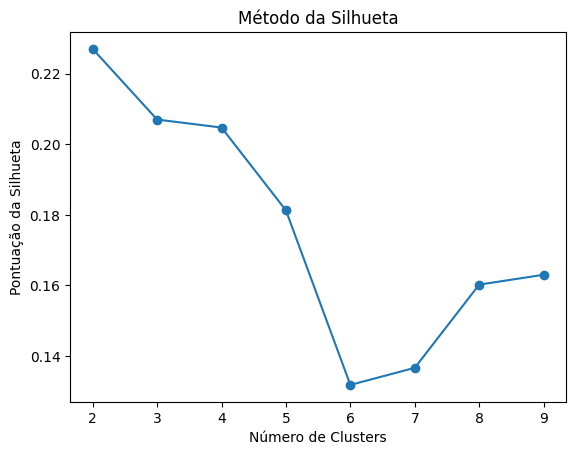

Melhor número de clusters baseado na pontuação da silhueta: 2


'\n\n* Para 2 clusters, a pontuação é a mais alta (~0.24), sugerindo que dividir os dados em 2 grupos resulta nos clusters mais bem definidos.\n\n* Com mais clusters (e.g., 3, 4, ou 5), a pontuação diminui, indicando que os clusters não estão tão bem separados ou coesos.\n\n* Há um novo pico em 7 clusters, indicando que essa pode ser uma divisão alternativa interessante, mas talvez mais difícil de interpretar.\n\n\nInterprete os Clusters para 2 e 7: Teste o modelo com ambos e veja qual oferece melhor desempenho na predição.\n\n'

In [65]:
silhouette_scores = []
range_clusters = range(2, 10)  # Começa em 2 porque 1 cluster não faz sentido para silhueta

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)  # Substitua 'data_scaled' pelos seus dados normalizados
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

# Plotar os resultados
plt.plot(range_clusters, silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Pontuação da Silhueta')
plt.title('Método da Silhueta')
plt.show()

# Melhor número de clusters
melhor_k = range_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Melhor número de clusters baseado na pontuação da silhueta: {melhor_k}")

'''

* Para 2 clusters, a pontuação é a mais alta (~0.24), sugerindo que dividir os dados em 2 grupos resulta nos clusters mais bem definidos.

* Com mais clusters (e.g., 3, 4, ou 5), a pontuação diminui, indicando que os clusters não estão tão bem separados ou coesos.

* Há um novo pico em 7 clusters, indicando que essa pode ser uma divisão alternativa interessante, mas talvez mais difícil de interpretar.


Interprete os Clusters para 2 e 7: Teste o modelo com ambos e veja qual oferece melhor desempenho na predição.

'''


In [66]:
kmeans = KMeans(n_clusters=2, random_state=42)
X_df['cluster'] = kmeans.fit_predict(X_df)
display(X_df.head(2))

,num__area,num__quartos,num__vagas_de_carro,num__valor_condominio,num__iptu,num__distancia_metro,num__distancia_escola,num__distancia_unidade_saude,num__indic_rend,num__indic_lixo,num__indic_esgo,num__indic_agua,cat__tipo_apartamento,cat__tipo_casa,cat__mobiliado_False,cat__mobiliado_True,cluster
0,0.279048,0.558079,1.191790,0.481263,-0.252861,-0.641417,-0.422028,-0.742904,2.056997,0.571315,0.757023,0.805148,1.0,0.0,1.0,0.0,1
1,-0.743283,-0.545298,-0.016326,-0.988846,-0.709822,0.439658,-1.101510,-1.330470,-1.367139,-1.396969,-0.146278,-0.696986,1.0,0.0,1.0,0.0,0


,num__area,num__quartos,num__vagas_de_carro,num__valor_condominio,num__iptu,num__distancia_metro,num__distancia_escola,num__distancia_unidade_saude,num__indic_rend,num__indic_lixo,num__indic_esgo,num__indic_agua,cat__tipo_apartamento,cat__tipo_casa,cat__mobiliado_False,cat__mobiliado_True
cluster,,,,,,,,,,,,,,,,
0,-0.437474,-0.383426,-0.425060,-0.502373,-0.248898,-0.043296,-0.357042,-0.399780,-0.459835,-0.192408,0.198069,-0.021173,0.910180,0.089820,0.904192,0.095808
1,0.794110,0.696001,0.771576,0.911916,0.451804,0.078591,0.648109,0.725687,0.834700,0.349263,-0.359538,0.038434,0.902174,0.097826,0.798913,0.201087


num__area                       0
num__quartos                    0
num__vagas_de_carro             0
num__valor_condominio           0
num__iptu                       0
num__distancia_metro            0
num__distancia_escola           0
num__distancia_unidade_saude    0
num__indic_rend                 0
num__indic_lixo                 0
num__indic_esgo                 0
num__indic_agua                 0
cat__tipo_apartamento           0
cat__tipo_casa                  0
cat__mobiliado_False            0
cat__mobiliado_True             0
cluster                         0
preco                           0
dtype: int64

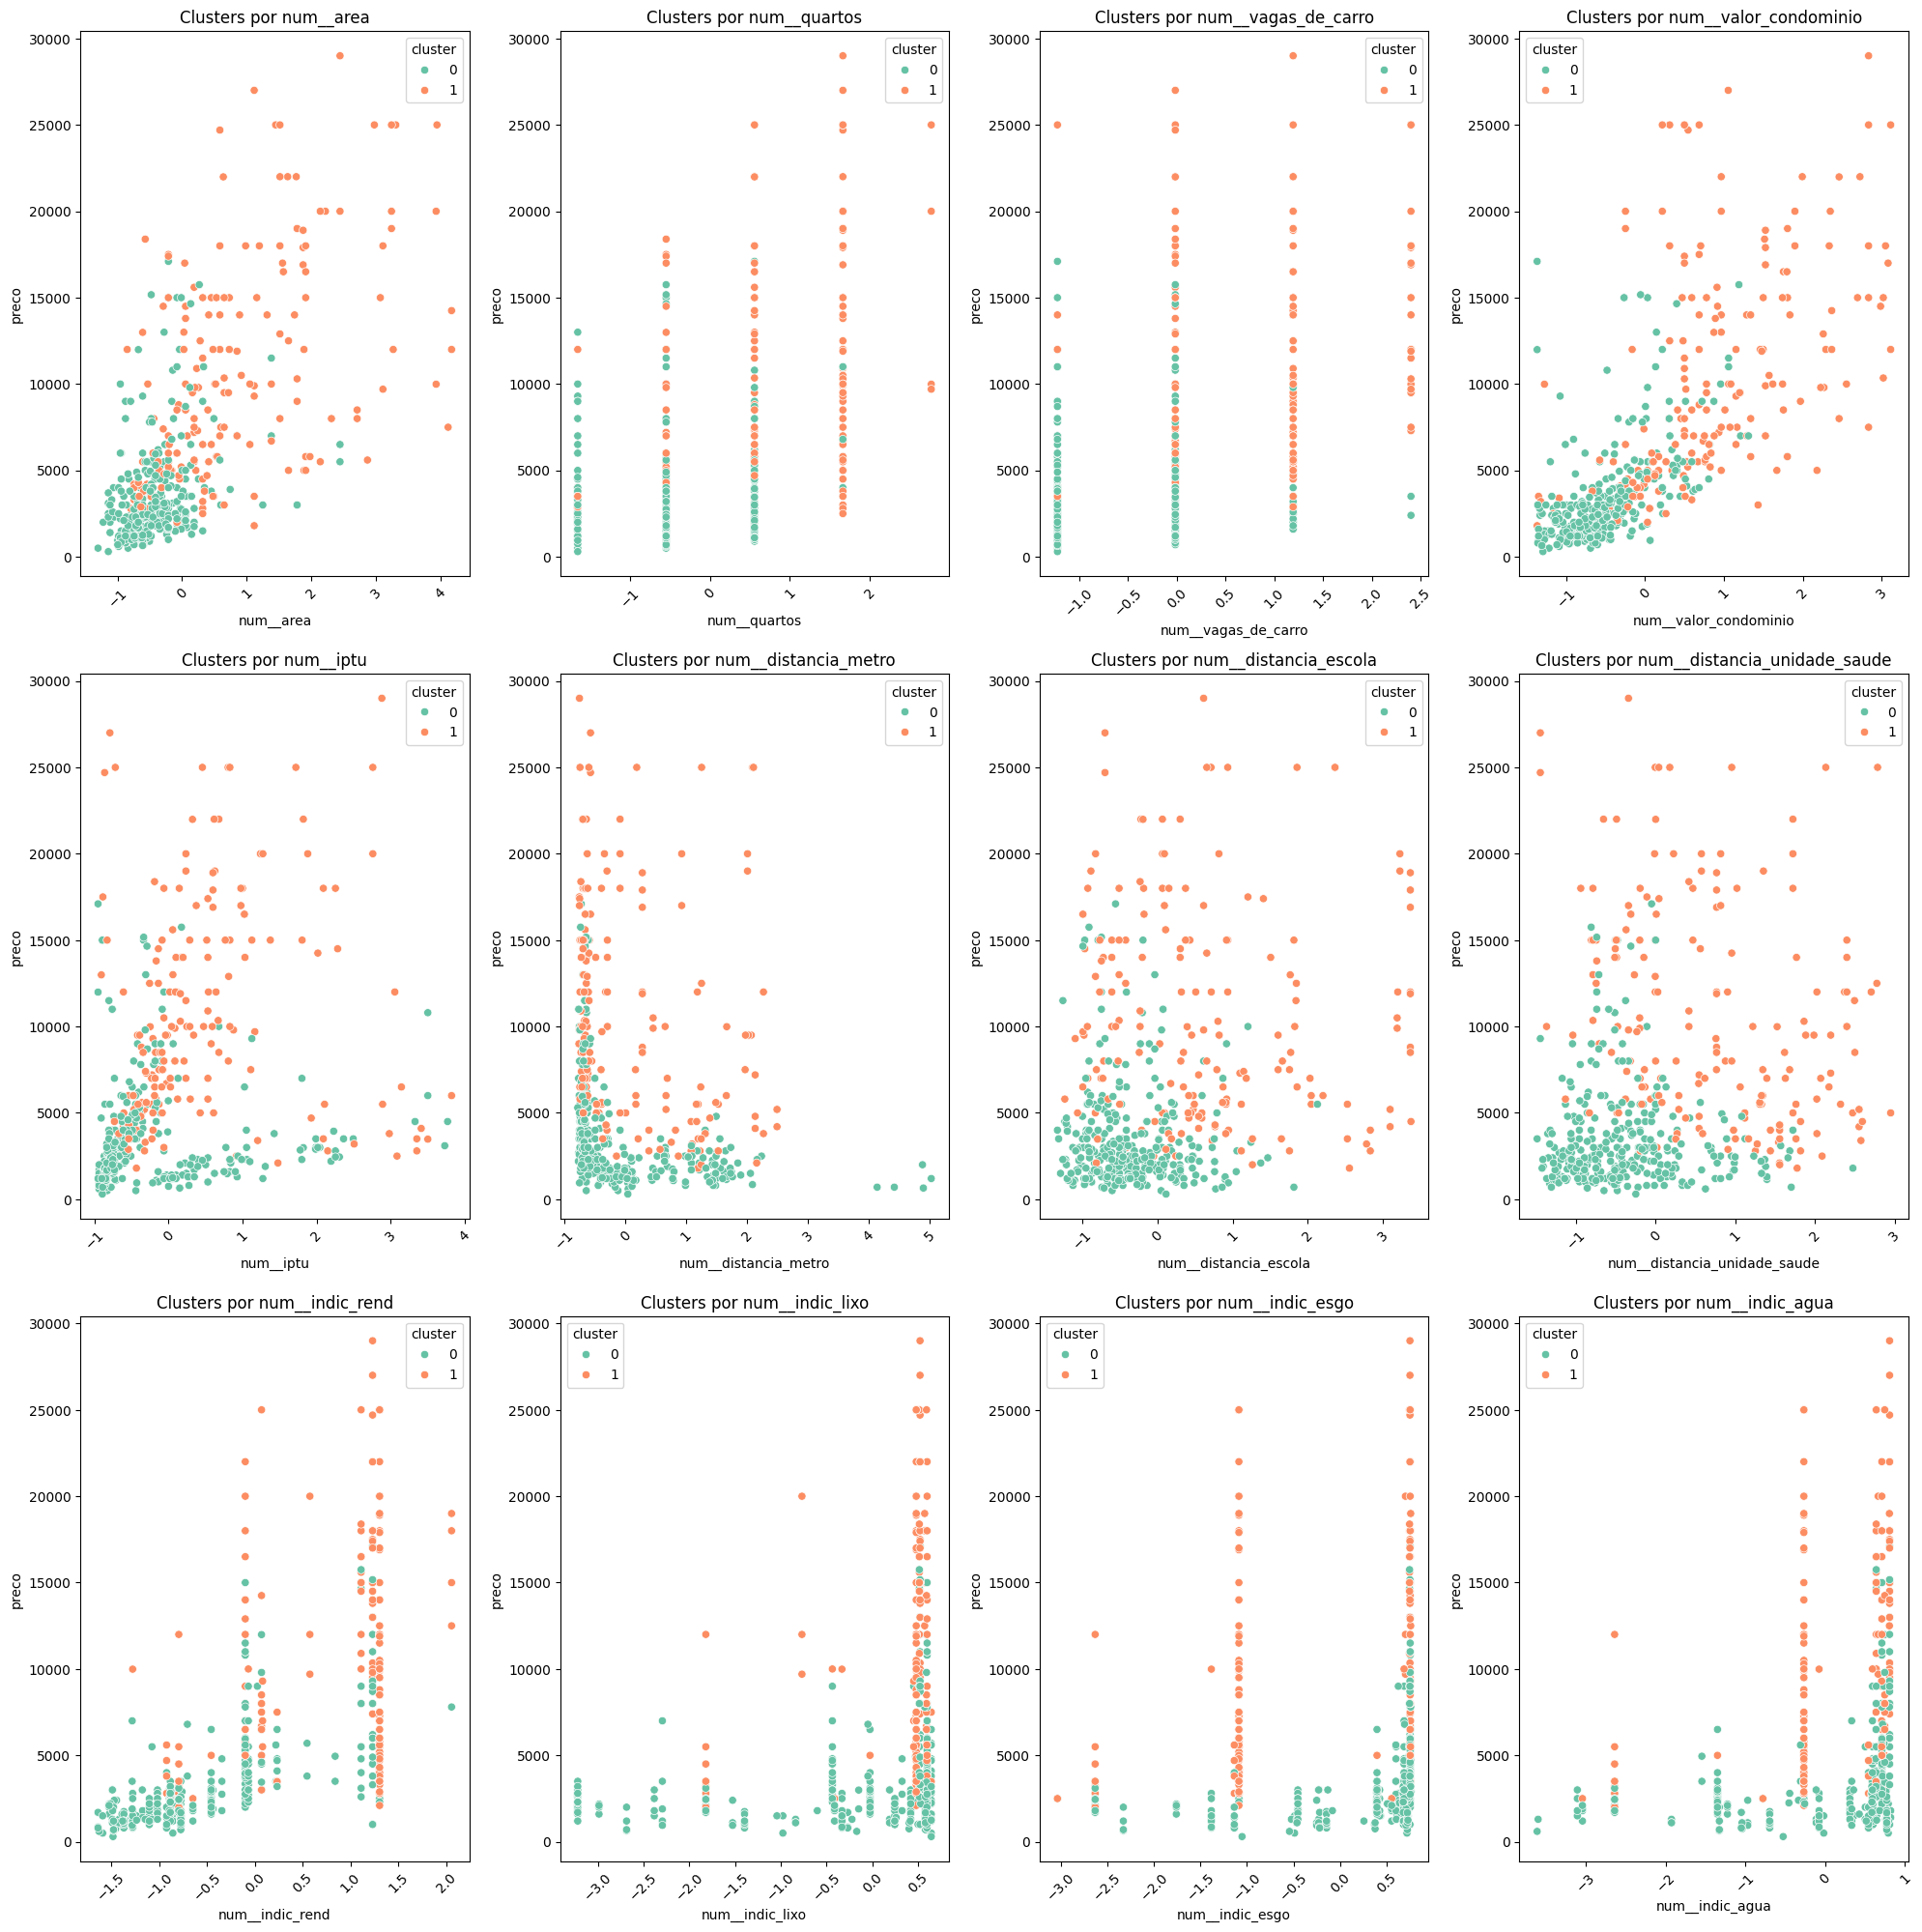

In [67]:
# Estatísticas descritivas
cluster_summary = X_df.groupby('cluster').mean()
display(cluster_summary)

X_df["preco"] = y

display(X_df.isna().sum())

# Visualização de clusters
fig, axes = plt.subplots(3, 4, figsize=(20, 20))
axes = axes.ravel()

numeric_cols = [col for col in X_df.columns if col.startswith('num__')]

for i, col in enumerate(numeric_cols):
    sns.scatterplot(x=col, y='preco', hue='cluster', data=X_df, palette='Set2', ax=axes[i])
    axes[i].set_title(f'Clusters por {col}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [68]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from modules_310 import testar_varios_modelos_paralelo



In [86]:
# cluster_0 = X_df[X_df['cluster'] == 0]

X_train_cluster_0, X_test_cluster_0, y_train_cluster_0, y_test_cluster_0 = train_test_split(X_df.drop('preco', axis=1), X_df['preco'], test_size=0.2, random_state=42)

In [87]:
# best_model, best_score = testar_varios_modelos_paralelo(X_train_cluster_0, X_test_cluster_0, y_train_cluster_0, y_test_cluster_0)
best_model = load_model(f'models/melhor_modelo_aluguel_cluster_0.keras')

best_model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                │ (None, 32)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,997 (19.52 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,332 (13.02 KB)

In [88]:
# Treinamento com Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = best_model.fit(
    X_train_cluster_0, y_train_cluster_0,
    validation_data=(X_test_cluster_0, y_test_cluster_0),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Previsão dos valores de teste
y_pred = best_model.predict(X_test_cluster_0).flatten()

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 13456535.0000 - mae: 2166.2039 - val_loss: 7872188.5000 - val_mae: 1614.4681
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12532097.0000 - mae: 2188.8027 - val_loss: 7869215.5000 - val_mae: 1614.2087
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12337255.0000 - mae: 2108.4487 - val_loss: 7868161.0000 - val_mae: 1614.1021
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15590460.0000 - mae: 2374.0305 - val_loss: 7866434.5000 - val_mae: 1613.9423
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9128497.0000 - mae: 1799.7451 - val_loss: 7864397.5000 - val_mae: 1613.7581
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13170963.0000 - mae: 2194.8613 - val_loss: 7862093.5000 - val_mae: 1613.5520
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13302731.0000 - mae: 2207.9160 - val_loss: 7860152.5000 - val_mae: 1613.3718
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [89]:
mae = mean_absolute_error(y_test_cluster_0, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_cluster_0, y_pred))
r2 = r2_score(y_test_cluster_0, y_pred)

# Exibindo as métricas de forma mais bonita
print(f"{'Métricas de Avaliação':^40}")
print(f"{'-'*40}")
print(f"{'MAE':<10}: {mae:.4f}")
print(f"{'RMSE':<10}: {rmse:.4f}")
print(f"{'R²':<10}: {r2:.4f}")
print(f"{'-'*40}")

         Métricas de Avaliação          
----------------------------------------
MAE       : 1603.6466
RMSE      : 2785.3508
R²        : 0.7178
----------------------------------------
